In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import r2_score

In [2]:
file = pd.read_csv('../dataset/full_COA_v3.csv.' , index_col='Time',parse_dates=True)
# filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
# df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
# print(df.shape)  # (123, 8)
df=pd.DataFrame(file,columns=['COA','temp','dewPoint','humidity','windSpeed'])
df.head()

,COA,temp,dewPoint,humidity,windSpeed
Time,,,,,
2012-01-01 01:00:00,5986.0,13.98,0.01,0.38,3.09
2012-01-01 02:00:00,5547.0,11.98,0.99,0.47,2.06
2012-01-01 03:00:00,5233.0,11.98,0.99,0.47,2.06
2012-01-01 04:00:00,5150.0,11.98,0.01,0.44,2.06
2012-01-01 05:00:00,5235.0,11.98,0.01,0.44,3.60


In [3]:
df = df.resample(rule = 'W').mean()

In [4]:
df

,COA,temp,dewPoint,humidity,windSpeed
Time,,,,,
2012-01-01,6168.434783,18.500000,0.957826,0.330870,2.842174
2012-01-08,6062.529762,15.680417,1.910179,0.415357,2.451190
2012-01-15,5891.416667,15.758512,3.856964,0.483155,3.174702
2012-01-22,6331.220238,12.311071,-3.359107,0.354405,2.623274
2012-01-29,6588.095238,12.812321,-5.018988,0.314405,2.533214
...,...,...,...,...,...
2017-12-03,7907.255368,18.473155,8.283333,0.538214,2.620238
2017-12-10,8479.933532,12.912738,-7.341548,0.265119,2.792917
2017-12-17,8763.204819,13.678095,-7.667976,0.252321,2.497321


C:\Users\HMA\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


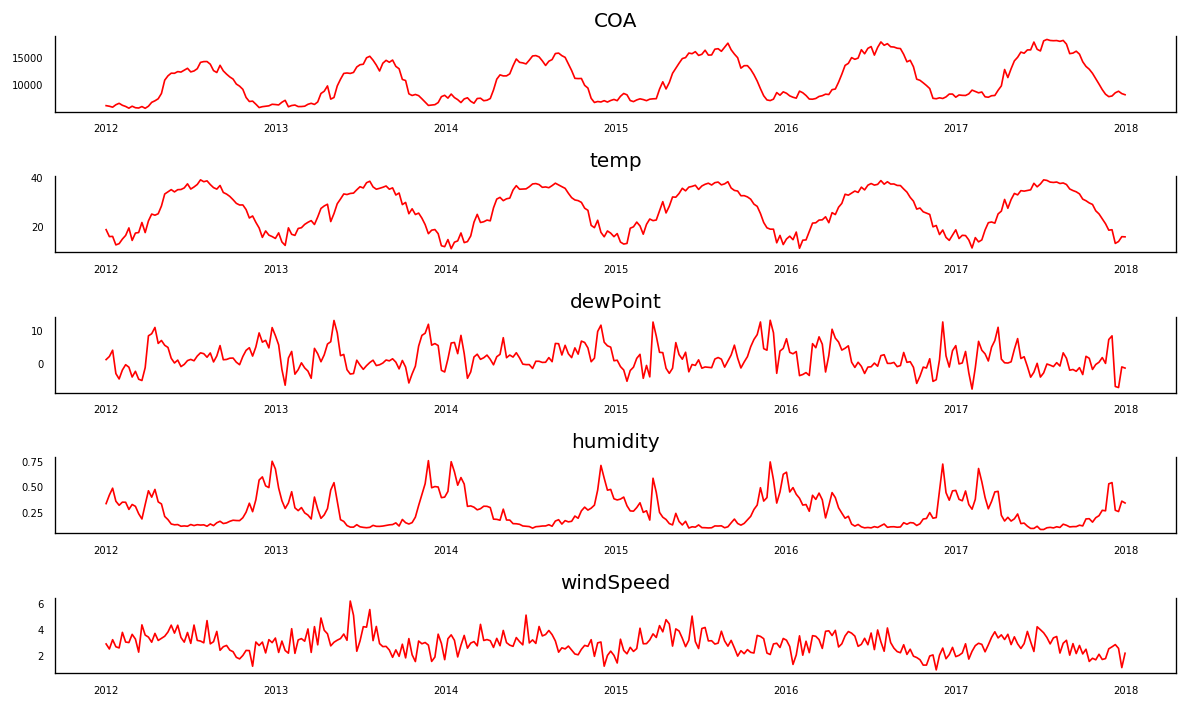

In [5]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=52
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,COA_x,temp_x,dewPoint_x,humidity_x,windSpeed_x
COA_y,1.0000,0.0000,0.0000,0.0001,0.0
temp_y,0.0002,1.0000,0.0003,0.0041,0.0
dewPoint_y,0.0017,0.0042,1.0000,0.0032,0.0
humidity_y,0.0000,0.0000,0.0000,1.0000,0.0
windSpeed_y,0.0000,0.0000,0.1948,0.0002,1.0


In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
COA    ::  185.26    > 60.0627   =>   True
temp   ::  111.44    > 40.1749   =>   True
dewPoint ::  62.6      > 24.2761   =>   True
humidity ::  21.19     > 12.3212   =>   True
windSpeed ::  0.15      > 4.1296    =>   False


In [9]:
nobs = 52
df_train, df_test = df[0:-nobs], df[-nobs:]


# Check size
print(df_train.shape)  
print(df_test.shape)  

(262, 5)
(52, 5)


In [10]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [11]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "COA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0946
 No. Lags Chosen       = 7
 Critical value 1%     = -3.456
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "temp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5835
 No. Lags Chosen       = 13
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "dewPoint" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0

In [13]:
# # 1st difference
# df_differenced = df_train.diff().dropna()

In [14]:
# ADF Test on each column of 1st Differences Dataframe
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [15]:
# Second Differencing
# df_differenced = df_differenced.diff().dropna()

In [16]:
# ADF Test on each column of 2nd Differences Dataframe
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [17]:
# Because the data is already stationary, I did not do the diff command
df_differenced=df_train

In [18]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  9.274610471529867
BIC :  9.684325460877302
FPE :  10664.235873324002
HQIC:  9.439302609653582 

Lag Order = 2
AIC :  9.03161034600334
BIC :  9.784831460256624
FPE :  8365.43023623431
HQIC:  9.334415255957238 

Lag Order = 3
AIC :  9.008089089084661
BIC :  10.106723239416564
FPE :  8175.333115054356
HQIC:  9.44980489014699 

Lag Order = 4
AIC :  8.921275559428729
BIC :  10.367247483524736
FPE :  7503.165480055243
HQIC:  9.502707804684167 

Lag Order = 5
AIC :  9.00943749531394
BIC :  10.804689989618915
FPE :  8208.375210698798
HQIC:  9.73139926614939 

Lag Order = 6
AIC :  9.08286370679796
BIC :  11.229357862635196
FPE :  8855.865391465735
HQIC:  9.946175708909028 

Lag Order = 7
AIC :  9.078697067754259
BIC :  11.5784125113955
FPE :  8850.153200533265
HQIC:  10.084187728691262 



In [20]:
# Another way to get the lag
x = model.select_order(maxlags=7)
x.summary()

,AIC,BIC,FPE,HQIC
0,14.37,14.44,1.744e+06,14.40
1,9.326,9.743*,1.123e+04,9.494
2,9.073,9.837,8722.,9.381*
3,9.035,10.15,8398.,9.482
4,8.951*,10.41,7731.*,9.538
5,9.029,10.83,8373.,9.755
6,9.093,11.25,8948.,9.959
7,9.079,11.58,8850.,10.08


In [21]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Dec, 2019
Time:                     16:28:25
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    10.3672
Nobs:                     258.000    HQIC:                   9.50271
Log likelihood:          -2876.28    FPE:                    7503.17
AIC:                      8.92128    Det(Omega_mle):         5073.67
--------------------------------------------------------------------
Results for equation COA
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const            -2239.935461      1126.660123           -1.988           0.047
L1.COA               1.055982         0.071671           14.734           0.000
L1.temp             59.938488        40.353578            1.485   

In [25]:
model_fitted.fittedvalues

,COA,temp,dewPoint,humidity,windSpeed
Time,,,,,
2012-01-29,6522.160243,15.565695,-0.624132,0.367082,2.327907
2012-02-05,6392.412792,14.991968,-0.405137,0.392289,2.798682
2012-02-12,6445.629236,15.875459,0.060244,0.393734,3.116923
2012-02-19,6164.231984,17.473437,0.550505,0.350531,3.095453
2012-02-26,5910.920389,19.717847,0.126751,0.295570,3.437342
...,...,...,...,...,...
2016-12-04,6853.483034,16.176662,4.137759,0.508501,1.900885
2016-12-11,7212.483137,15.805295,7.755723,0.590463,2.317533
2016-12-18,7549.772771,15.831853,-0.976234,0.342780,1.803627


In [26]:
model_fitted.k_ar

4

In [27]:
# from statsmodels.stats.stattools import durbin_watson
# out = durbin_watson(model_fitted.resid)

# for col, val in zip(df.columns, out):
#     print(adjust(col), ':', round(val, 2))

In [22]:
df_differenced.values

array([[ 6.16843478e+03,  1.85000000e+01,  9.57826087e-01,
         3.30869565e-01,  2.84217391e+00],
       [ 6.06252976e+03,  1.56804167e+01,  1.91017857e+00,
         4.15357143e-01,  2.45119048e+00],
       [ 5.89141667e+03,  1.57585119e+01,  3.85696429e+00,
         4.83154762e-01,  3.17470238e+00],
       ...,
       [ 8.25229167e+03,  1.41467262e+01, -1.35101190e+00,
         3.64404762e-01,  2.01464286e+00],
       [ 8.25460714e+03,  1.62630952e+01,  3.71303571e+00,
         4.56250000e-01,  2.57500000e+00],
       [ 7.68911905e+03,  1.84313690e+01,  5.26684524e+00,
         4.61250000e-01,  1.85464286e+00]])

In [27]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

# Input data for forecasting
forecast_input = df_differenced.values[lag_order:]
forecast_input

4


array([[ 6.58809524e+03,  1.28123214e+01, -5.01898810e+00,
         3.14404762e-01,  2.53321429e+00],
       [ 6.23337500e+03,  1.46750595e+01, -2.25321429e+00,
         3.45178571e-01,  3.74672619e+00],
       [ 6.02255357e+03,  1.61459524e+01, -6.17202381e-01,
         3.43988095e-01,  2.99119048e+00],
       ...,
       [ 8.25229167e+03,  1.41467262e+01, -1.35101190e+00,
         3.64404762e-01,  2.01464286e+00],
       [ 8.25460714e+03,  1.62630952e+01,  3.71303571e+00,
         4.56250000e-01,  2.57500000e+00],
       [ 7.68911905e+03,  1.84313690e+01,  5.26684524e+00,
         4.61250000e-01,  1.85464286e+00]])

In [39]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns)
df_forecast

,COA,temp,dewPoint,humidity,windSpeed
Time,,,,,
2017-01-08,7517.662681,17.168513,2.838536,0.418388,2.781722
2017-01-15,7439.889624,17.143789,0.992703,0.364920,2.497154
2017-01-22,7303.285130,17.091866,0.858026,0.361183,2.550002
2017-01-29,7045.029747,17.142359,1.439829,0.386887,2.671506
2017-02-05,7026.808544,17.567562,1.978380,0.394227,2.795856
2017-02-12,7063.593644,17.975722,2.057826,0.385698,2.752497
2017-02-19,7100.908396,18.438374,2.248690,0.380803,2.820887
2017-02-26,7202.531072,18.875702,2.238069,0.375242,2.931103
2017-03-05,7364.414716,19.354066,2.186450,0.368054,2.976567


In [40]:
df_forecast

,COA,temp,dewPoint,humidity,windSpeed
Time,,,,,
2017-01-08,7517.662681,17.168513,2.838536,0.418388,2.781722
2017-01-15,7439.889624,17.143789,0.992703,0.364920,2.497154
2017-01-22,7303.285130,17.091866,0.858026,0.361183,2.550002
2017-01-29,7045.029747,17.142359,1.439829,0.386887,2.671506
2017-02-05,7026.808544,17.567562,1.978380,0.394227,2.795856
2017-02-12,7063.593644,17.975722,2.057826,0.385698,2.752497
2017-02-19,7100.908396,18.438374,2.248690,0.380803,2.820887
2017-02-26,7202.531072,18.875702,2.238069,0.375242,2.931103
2017-03-05,7364.414716,19.354066,2.186450,0.368054,2.976567


COA AxesSubplot(0.125,0.657941;0.352273x0.222059)
temp AxesSubplot(0.547727,0.657941;0.352273x0.222059)
dewPoint AxesSubplot(0.125,0.391471;0.352273x0.222059)
humidity AxesSubplot(0.547727,0.391471;0.352273x0.222059)
windSpeed AxesSubplot(0.125,0.125;0.352273x0.222059)


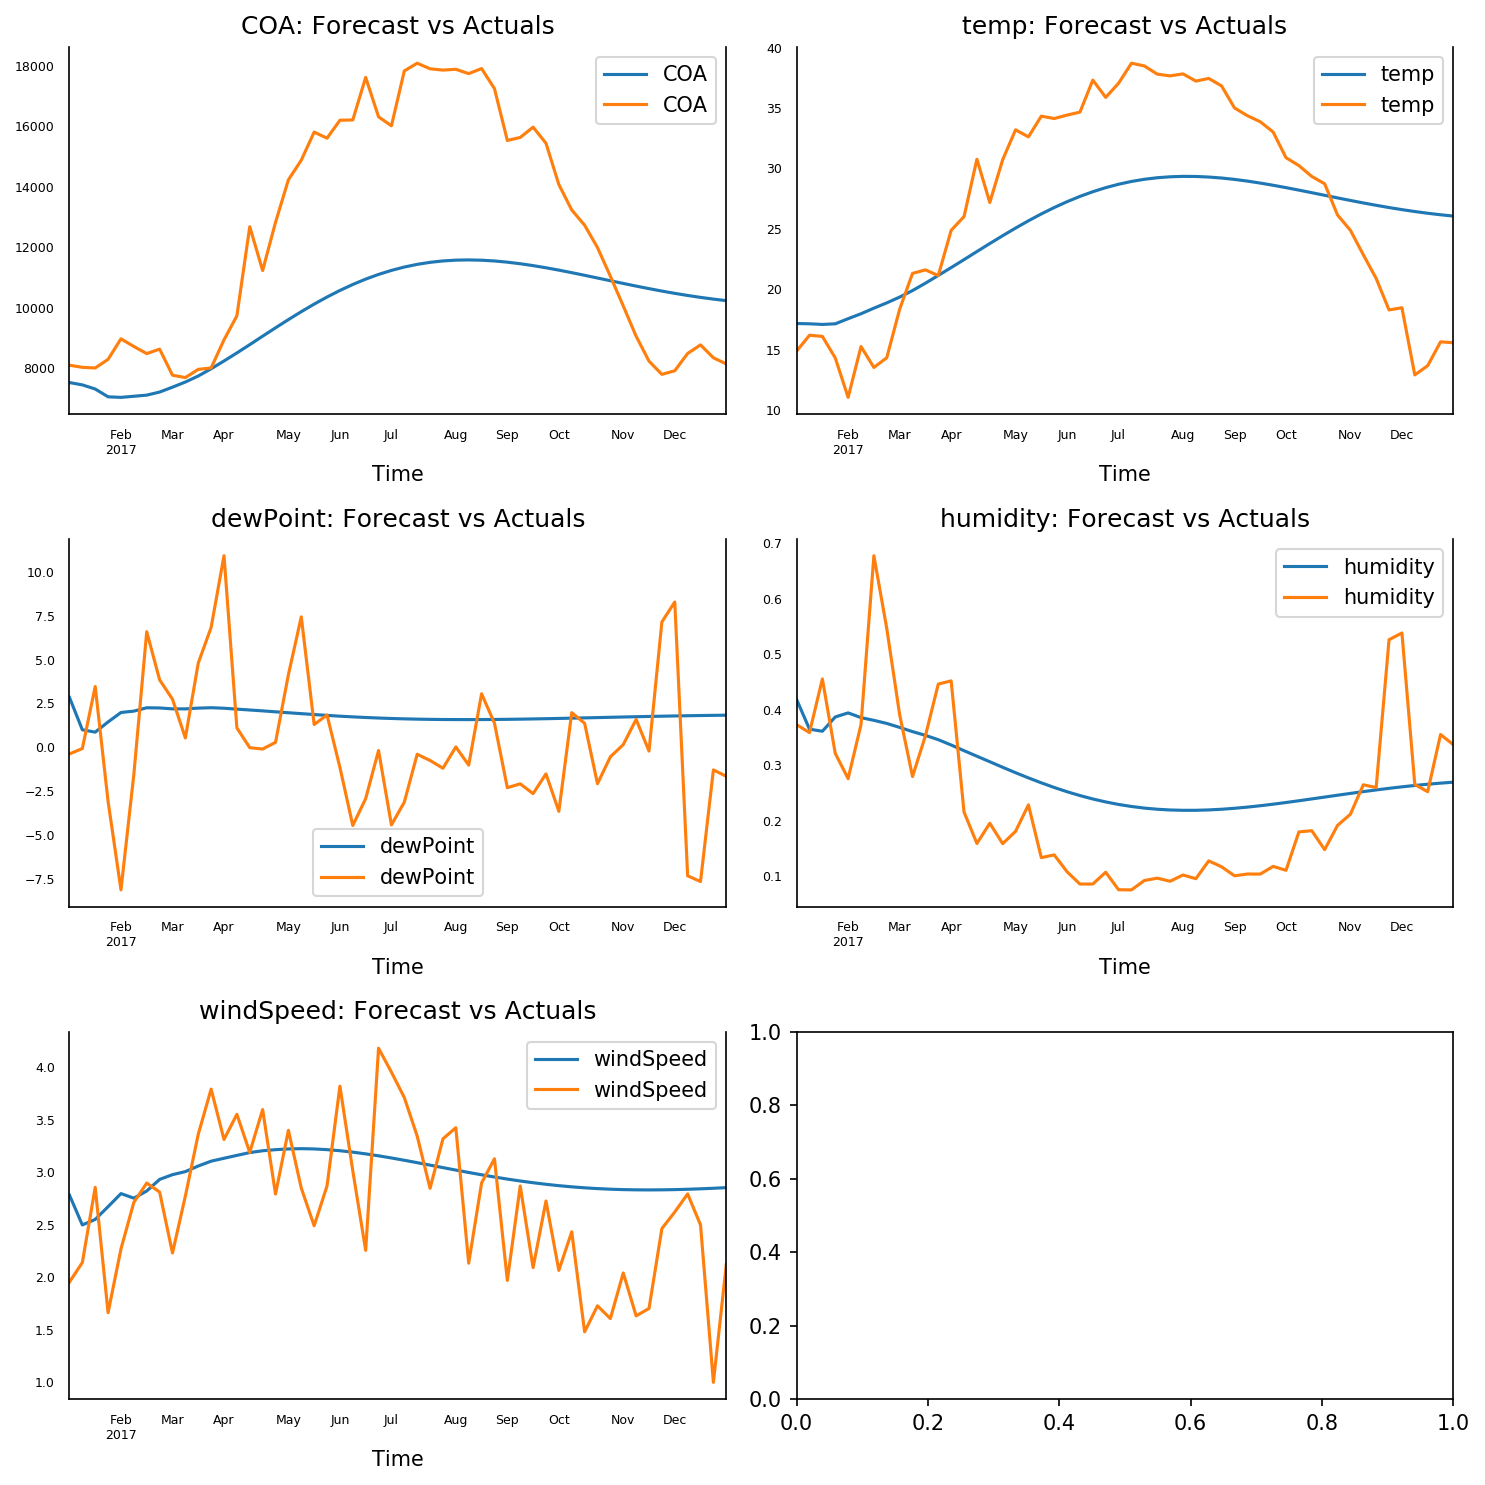

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    print (col,ax)
    df_forecast[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [47]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})



In [55]:
print('Forecast Accuracy of: COA')
accuracy_prod = forecast_accuracy(df_forecast['COA'].values, df_test['COA'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: temp')
accuracy_prod = forecast_accuracy(df_forecast['temp'].values, df_test['temp'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dewPoint')
accuracy_prod = forecast_accuracy(df_forecast['dewPoint'].values, df_test['dewPoint'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: humidity')
accuracy_prod = forecast_accuracy(df_forecast['humidity'].values, df_test['humidity'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: windSpeed')
accuracy_prod = forecast_accuracy(df_forecast['windSpeed'].values, df_test['windSpeed'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))



Forecast Accuracy of: COA
mape :  0.2279
me :  -2450.946
mae :  3129.6635
mpe :  -0.1462
rmse :  3805.5204
corr :  0.7232
minmax :  0.2195

Forecast Accuracy of: temp
mape :  0.2388
me :  -1.6808
mae :  5.7071
mpe :  0.0235
rmse :  6.5952
corr :  0.7489
minmax :  0.1929

Forecast Accuracy of: dewPoint
mape :  6.2059
me :  1.5208
mae :  3.3034
mpe :  -1.0576
rmse :  4.087
corr :  0.2624
minmax :  1.5315

Forecast Accuracy of: humidity
mape :  0.6821
me :  0.0453
mae :  0.1037
mpe :  0.5652
rmse :  0.1219
corr :  0.7083
minmax :  0.3549

Forecast Accuracy of: windSpeed
mape :  0.2628
me :  0.2876
mae :  0.5442
mpe :  0.1922
rmse :  0.6786
corr :  0.6126
minmax :  0.1792
